<a href="https://colab.research.google.com/github/VincentK1991/Sketch2code_with_attention/blob/master/notebook/Visualizing_result_Jun09_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing results

In this notebook, we will look at attention, and generating some HTML code and see how it looks compared to the input.

0. Download the packages, validation dataset, and the trained model

1. Attention visualization 

  forward pass the input and get the attention weights. Plot the image, and highlight the attention weights on top of the image to see what region of the image that the attention is focused on.
  - The interpretation of the attention weights is that it is a weight of relevance, i.e. which pixels in the image is relevant for generating the next token. 

3. compile the result to HTML

  Generate the output tokens using beam-search, map it back to the .gui code, and compile into the HTML.



# 0 Download the packages, the validation dataset, and the trained models

In [0]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
import json
from PIL import Image
import torch
import pandas as pd
from torch.nn.utils.rnn import pack_padded_sequence
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
import torch.backends.cudnn as cudnn
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead
from model import encoder, decoder
from torch.utils.data import DataLoader

In [0]:
val_dataset = torch.load('torch_valFile_Jun07_2020.pt')
df_val = pd.read_csv('val_PADDED_tokenized_data_May28_2020.csv',index_col=0).reset_index()
df_val.tail(5)

,level_0,index,gui,png,tokenized_line,tokenized_word
194,1694,1694,data/FDF12CF5-A344-4573-A239-78AE47DBEE78.gui,data/FDF12CF5-A344-4573-A239-78AE47DBEE78.png,"[11, 5, 2, 10, 7, 4, 9, 10, 4, 9, 10, 10, 7, 8...","[17, 7, 15, 5, 4, 8, 3, 1, 4, 8, 3, 1, 4, 8, 3..."
195,1695,1695,data/FDF4126C-C97E-43F0-9624-2AFC2D6BAD69.gui,data/FDF4126C-C97E-43F0-9624-2AFC2D6BAD69.png,"[11, 5, 3, 10, 7, 8, 9, 10, 10, 7, 4, 9, 10, 4...","[17, 7, 15, 5, 4, 8, 3, 1, 4, 8, 3, 1, 4, 8, 3..."
196,1696,1696,data/FE835309-7DF4-4141-B6D1-F0141AC1DBFD.gui,data/FE835309-7DF4-4141-B6D1-F0141AC1DBFD.png,"[11, 5, 1, 10, 7, 4, 9, 10, 4, 9, 10, 10, 7, 8...","[17, 7, 15, 5, 4, 8, 3, 1, 4, 8, 3, 1, 4, 8, 1..."
197,1697,1697,data/FECC1897-8B91-426B-96F3-29DA91E30721.gui,data/FECC1897-8B91-426B-96F3-29DA91E30721.png,"[11, 5, 1, 10, 7, 4, 9, 10, 4, 9, 10, 10, 7, 6...","[17, 7, 15, 5, 4, 8, 3, 1, 4, 8, 3, 1, 4, 8, 1..."
198,1698,1698,data/FEF248A4-868E-4A6C-94D6-9B38A67974F0.gui,data/FEF248A4-868E-4A6C-94D6-9B38A67974F0.png,"[11, 5, 2, 10, 7, 6, 9, 10, 6, 9, 10, 6, 9, 10...","[17, 7, 15, 5, 4, 8, 3, 1, 4, 8, 3, 1, 4, 8, 3..."


In [0]:
with open('line2idx.json', 'r') as f:
    line2idx = json.load(f)

idx2line = {}
for item in line2idx.keys():
  idx2line[line2idx[item]] = item

In [0]:
encoder_model = encoder.Encoder(14)
encoder_model.fine_tune(True)
emb_dim = 256  # dimension of word embeddings
attention_dim = 256  # dimension of attention linear layers
decoder_dim = 256  # dimension of decoder RNN
dropout = 0.5

decoder_model = decoder.Decoder(attention_dim=attention_dim,
                                embed_dim=emb_dim,
                                decoder_dim=decoder_dim,
                                vocab_size=len(line2idx),
                                dropout=dropout)

decoder_model = decoder_model.to(device)
encoder_model = encoder_model.to(device)

state_dict_encoder = torch.load('encoder_10_epoch_2_Jun01_2020.pt')['state_dict']
encoder_model.load_state_dict(state_dict_encoder)

state_dict_decoder = torch.load('decoder_10_epoch_2_Jun01_2020.pt')['state_dict']
decoder_model.load_state_dict(state_dict_decoder)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


<All keys matched successfully>

# 1. Attention visualization

define 2 helper functions

this is just to help do the forward pass, and create the image plot

In [0]:
def get_result(batch):
  """
  Forward pass the input data to the model and get the output
  input: batch
  output: scores = 
          cap_sorted = tokenized_output sorted by length
          decode_lengths = length of the output
          alphas = attention weight
          sort_ind = index of the sorting. Currently this feature is not used.
  """

  decoder_model.eval()  # eval mode (no dropout or batchnorm)
  encoder_model.eval()

  imgs = batch[0].unsqueeze(0)
  caps = batch[1].unsqueeze(0)
  caplens = batch[2].unsqueeze(0)

  with torch.no_grad():
    imgs = imgs.to(device)
    caps = caps.to(device)
    caplens = caplens.to(device)

    imgs = encoder_model(imgs)
    scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder_model(imgs, caps, caplens)
  
  return scores, caps_sorted, decode_lengths, alphas, sort_ind 

In [0]:
def visualize_att(image_path, seq, alphas, rev_word_map,num_row=6,num_col=5,figwidth=20,figheight=15, smooth=True):
    """
    Visualizes caption with weights at every word.
    input:
            image_path: path to image that has been captioned
            seq: caption
            alphas: weights
            rev_word_map: reverse word mapping, i.e. ix2word
            smooth: smooth weights
    """
    img = Image.open(image_path)
    image = img.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq if ind not in [13]]
    #print(words)
    f, ax = plt.subplots(num_row,num_col,figsize=(figwidth,figheight))
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    #print('len of words ',len(words))
    for t in range(len(words)):
        #print(t)
        #print('  ')
        #print('t = ', t)
        if t > 50:
            break
        row = int(t/num_col)
        col = int(t%num_col)
        #plt.subplot(np.ceil(len(words) / 5), 5, t + 1,figsize=(10,10))

        ax[row,col].text(6, 5, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        ax[row,col].imshow(image)
        if t < len(words) - 1:
          current_alpha = alphas[t, :]
        else:
          current_alpha = alphas[0,:]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
            #print(' smooth step alpha dim ', alpha.shape)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
        if t == 0:
            ax[row,col].imshow(alpha, alpha=0)
        elif t == len(words)-1:
            #print('here here')
            ax[row,col].imshow(alpha, alpha=0)
        else:
            ax[row,col].imshow(alpha, alpha=0.5)
        plt.set_cmap(cm.Greys_r)
        ax[row,col].axis('off')
    plt.tight_layout()

define the function that call both helper functions

In [0]:
def execute_attention_viz(batch,image_path,rev_word_map,num_row=3,num_col=7,figwidth=20,figheight=15):

  scores, caps_sorted, decode_lengths, alphas, sort_ind = get_result(batch)
  visualize_att(image_path,list(caps_sorted.detach().cpu().numpy()[0]),
                alphas.squeeze(0).view(decode_lengths[0],14,-1).detach().cpu(),rev_word_map,num_row,num_col,figwidth,figheight)

generate a result

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


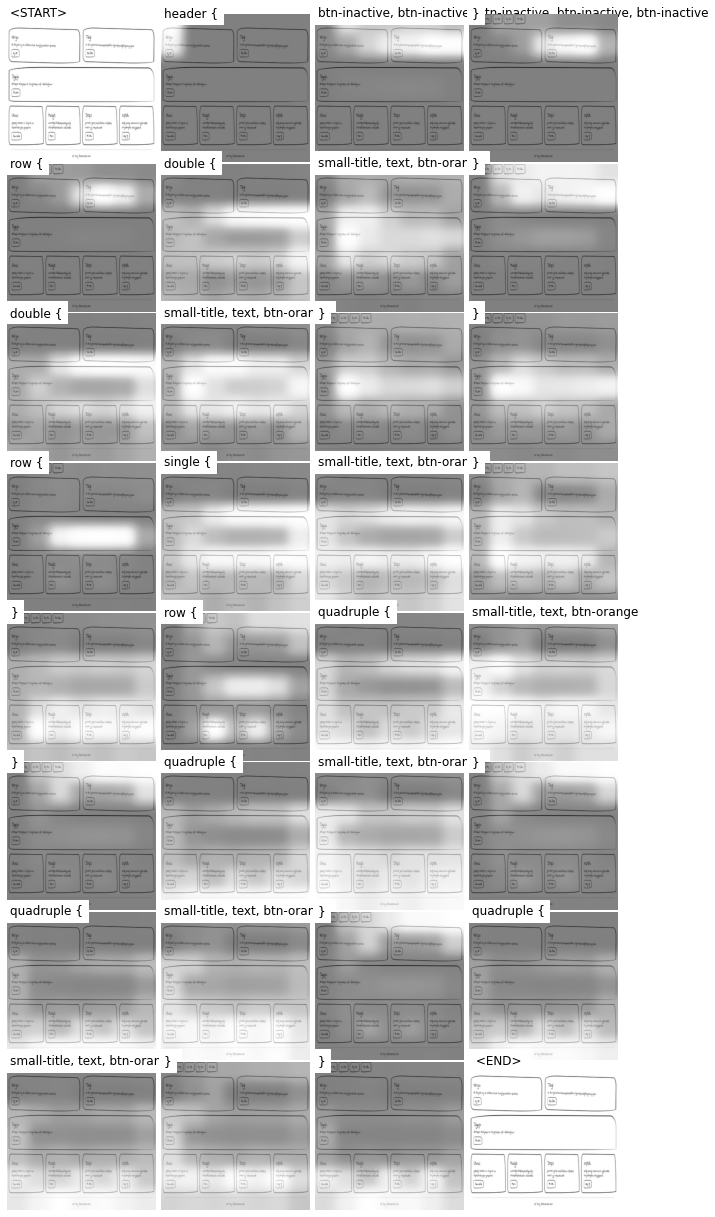

In [0]:
num = 0
execute_attention_viz(val_dataset[num],df_val['png'][num],idx2line,num_row=8,num_col=4,figwidth=11,figheight=22)

# 2. Compile the generated token result to HTML

define 2 helper functions

1. call the model to generate a tokenized output using beam-search algorithm

2. translate the tokenized result to .gui syntax, then compile to HTML using the code written by the original author: Tony Beltramelli (whose name is in the sketch images).

In [0]:
import IPython
from IPython.display import display, HTML
from inference.Compiler import *

In [0]:
def get_beam_search_result(batch,beam_size=3):
  """
  Perform validation of 1 batch input. This validation does not use teacher forcing.
  Thus the generation uses beam-search.
  each batch has strictly 1 sample (i.e. batch of 1)

  return the beam search result (one with highest probability), and accuracy
  """
  decoder_model.eval()  # eval mode (no dropout or batchnorm)
  encoder_model.eval()

  imgs = batch[0].unsqueeze(0)
  caps = batch[1].unsqueeze(0)
  caplens = batch[2].unsqueeze(0) #.unsqueeze(0)
  k = beam_size
  vocab_size = len(line2idx)
  references = list()  # references (true captions) for calculating BLEU-4 score
  hypotheses = list()  # hypotheses (predictions)
  with torch.no_grad():
    imgs = imgs.to(device)
    caps = caps.to(device)
    caplens = caplens.to(device)

    encoder_out = encoder_model(imgs)
    beam_search_seq = decoder_model.generate(encoder_out,line2idx,beam_size)
  
  allcaps = caps
  for j in range(allcaps.shape[0]):
    #print('j ',j)
    img_caps = allcaps[j].tolist()

    img_captions = []
    for w in img_caps:
      if w not in [line2idx['<PAD>']]:
      #if w not in [line2idx['<EOS>'],line2idx['<BOS>'], line2idx['<PAD>']]:
        img_captions.append(w)
    references.append(img_captions)

  accuracy = np.sum(np.where(np.array(beam_search_seq) == np.array(references[0]),1,0))/len(references[0])

  return beam_search_seq,accuracy

In [0]:
def translate_display_result(generated_result,rev_word_map):
  """
  print the HTML figure from the seq
  parameter: generated_result = list of integer index
  map it back to lines
  """
  rev_word_map[11] = '<START> '
  rev_word_map[12] = ' <END>'
  lines = []
  for i in generated_result:
    lines.append(rev_word_map[i])
  #print(lines)
  temp_compiler = Compiler('default')
  compiled_HTML = temp_compiler.compile(lines)
  del temp_compiler
  display(HTML(compiled_HTML))
  return compiled_HTML

generate 1 result

(-0.5, 2399.5, 1379.5, -0.5)

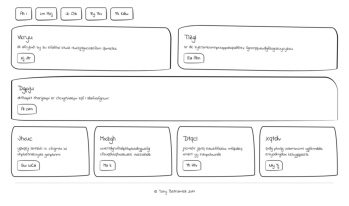

In [0]:
num = 0
img = Image.open(df_val['png'][num])
img
plt.imshow(np.array(img))
plt.axis('off')

In [0]:
seq1, accu1 = get_beam_search_result(val_dataset[num])
HTML0 = translate_display_result(seq1,idx2line)

In [0]:
print(HTML0)

<html>
  <header>
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1">
    <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.7/css/bootstrap.min.css" integrity="sha384-BVYiiSIFeK1dGmJRAkycuHAHRg32OmUcww7on3RYdg4Va+PmSTsz/K68vbdEjh4u" crossorigin="anonymous">
<link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.7/css/bootstrap-theme.min.css" integrity="sha384-rHyoN1iRsVXV4nD0JutlnGaslCJuC7uwjduW9SVrLvRYooPp2bWYgmgJQIXwl/Sp" crossorigin="anonymous">
<style>
.header{margin:20px 0}nav ul.nav-pills li{background-color:#333;border-radius:4px;margin-right:10px}.col-lg-3{width:24%;margin-right:1.333333%}.col-lg-6{width:49%;margin-right:2%}.col-lg-12,.col-lg-3,.col-lg-6{margin-bottom:20px;border-radius:6px;background-color:#f5f5f5;padding:20px}.row .col-lg-3:last-child,.row .col-lg-6:last-child{margin-right:0}footer{padding:20px 0;text-align:center;border-top:1px solid #bbb}
</style>
    <title>Scaffol